### Местай Мурзабаев [318]
# Кластеризация методом k-средних

## I. Реализация

### Подключим библиотеки

In [1]:
import numpy as np
import pandas as pd
import random
import time
%matplotlib inline
import matplotlib.pyplot as plt

### Генератор кластеров make_blobs()

В данной реализации есть вероятность близкого взаиморасположения точек, инициализирующих пучки, что может привести к наложению пучков - об этом нужно помнить при вызове функции.

In [2]:
def generate_point(mean, deviation):
    return random.gauss(mean[0], deviation[0]), random.gauss(mean[1], deviation[1])

def make_blobs(number_of_clusters,
               points_per_cluster,
               cluster_mean,
               cluster_deviation,
               point_deviation):
    number_of_points = number_of_clusters * points_per_cluster
    
    points = np.empty(shape=(number_of_points,2))
    cluster_number = np.empty(number_of_points)
    
    shift = 0
    for i in range(number_of_clusters):
        init_point = generate_point(cluster_mean, cluster_deviation)
        for j in range(points_per_cluster):
            points[shift+j] = generate_point(init_point, point_deviation)
            cluster_number[shift+j] = i
        shift += points_per_cluster

    return points, cluster_number

## Работа генератора кластеров на графике

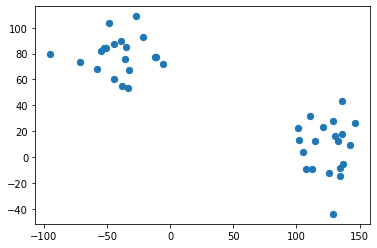

In [3]:
X, _ = make_blobs(number_of_clusters=2,
                  points_per_cluster=20,
                  cluster_mean=np.array((0,0)),
                  cluster_deviation=np.array((100,100)),
                  point_deviation=np.array((20,20)))
plt.scatter(X[:,0], X[:,1], 40)

### Функция кластеризации

In [4]:
from math import sqrt

def distance(a, b):
    return sqrt(((b[0] - a[0])**2) + ((b[1] - a[1])**2))

def kmeans(k, points, max_iters = 1000):
    number_of_points = len(points)
    
    # 1) выбираем k рандомных точек-центроидов и создаем для каждой отдельный массив
    centroids = np.empty(shape=(k,2))
    for i in range(k):
        repeat = True
        while (repeat):
            centroids[i] = random.choice(points)
            repeat = False
            for j in range(i):
                if centroids[j][0] == centroids[i][0] and centroids[j][1] == centroids[i][1]:
                    repeat = True
                    break
                    
    for _ in range(max_iters):
        # 2) сортируем оставшиеся точки по принадлежности ближней точке-центроиду
        break_time = True
        cluster_number = np.zeros(number_of_points)
        for i in range(number_of_points):
            min = 1000
            for j in range(k):
                dist = distance(points[i], centroids[j])
                if dist < min:
                    min = dist
                    if (cluster_number[i] != j):
                        break_time = False
                        cluster_number[i] = j
        if (break_time):
            break
            
        # 3) в k кластерах находим новую точку-центроид
        coords_sum = np.zeros(shape=(k,2))
        den = np.zeros(shape=(k,1))
        for i in range(k):
            for j in range(number_of_points):
                if (cluster_number[j] == i):
                    coords_sum[i] += points[j]
                    den[i] += 1
        centroids = coords_sum / den
    
    return cluster_number

### Результат кластеризации на графике

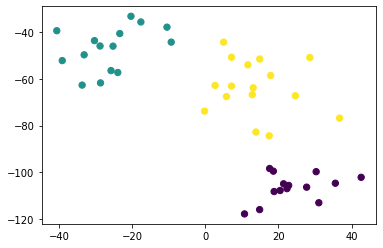

In [5]:
X, _ = make_blobs(number_of_clusters=3,
                  points_per_cluster=15,
                  cluster_mean=np.array((0,0)),
                  cluster_deviation=np.array((50,50)),
                  point_deviation=np.array((10,10)))
z = kmeans(3,X)
plt.scatter(X[:,0], X[:,1], 40, c=z)

## II. Исследования

### 1) Зависимость от стратегии начальной инициализации

Алгоритм хорошо работает, если расстояние между пучками точек (cluster_deviation) не намного больше их размера (point_deviation). В противной ситуации, когда небольшие пучки расположены далеко друг от друга, велик шанс того, что начальные центроиды будут выбраны неравномерно, т.е. в некоторых пучках окажется несколько центроидов, а в других не окажется в принципе, тогда большое расстояние между пучками не позволит алгоритму сойтись корректно. Например, вместо адекватного разделения как на верхнем изображении может произойти нечто похожее на нижнее изображение. Эта проблема может быть решена выбором оптимально отдаленных друг от друга центроидов или многократным вызовом функции.
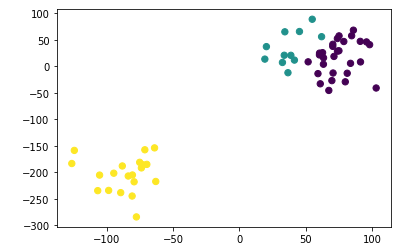
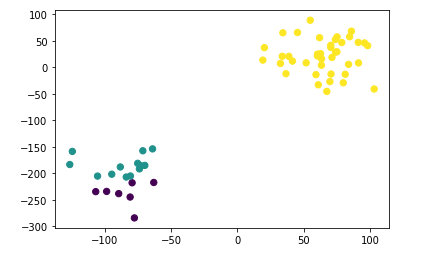

### 2) Для каких задач подходит/не подходит
Алгоритм не применим, если количество кластеров неизвестно или же необходима гарантия нахождения глобального минимума суммарного квадратичного отклонения. Алгоритм полезен, если для задачи достаточно приближенного решения, а также известно количество кластеров.

### 3) Стратегия выбора числа кластеров
Можно предложить следующую стратегию (т.н. Метод локтя) выбора k - запускать kmeans для k = 2,3,...,n и фиксировать значение S(k) - сумму квадратов отклонений точек кластеров от своих центроидов. Предлагается выбрать k такой, что разница между S(k+1) и S(k) несущественна, т.е. мы стараемся уменьшить сумму квадратов отклонений точек от центроидов, при этом не выбирая слишком большое значение k. На изображенном ниже примере исходя из данной стратегии выберем k равный 4 или 5.
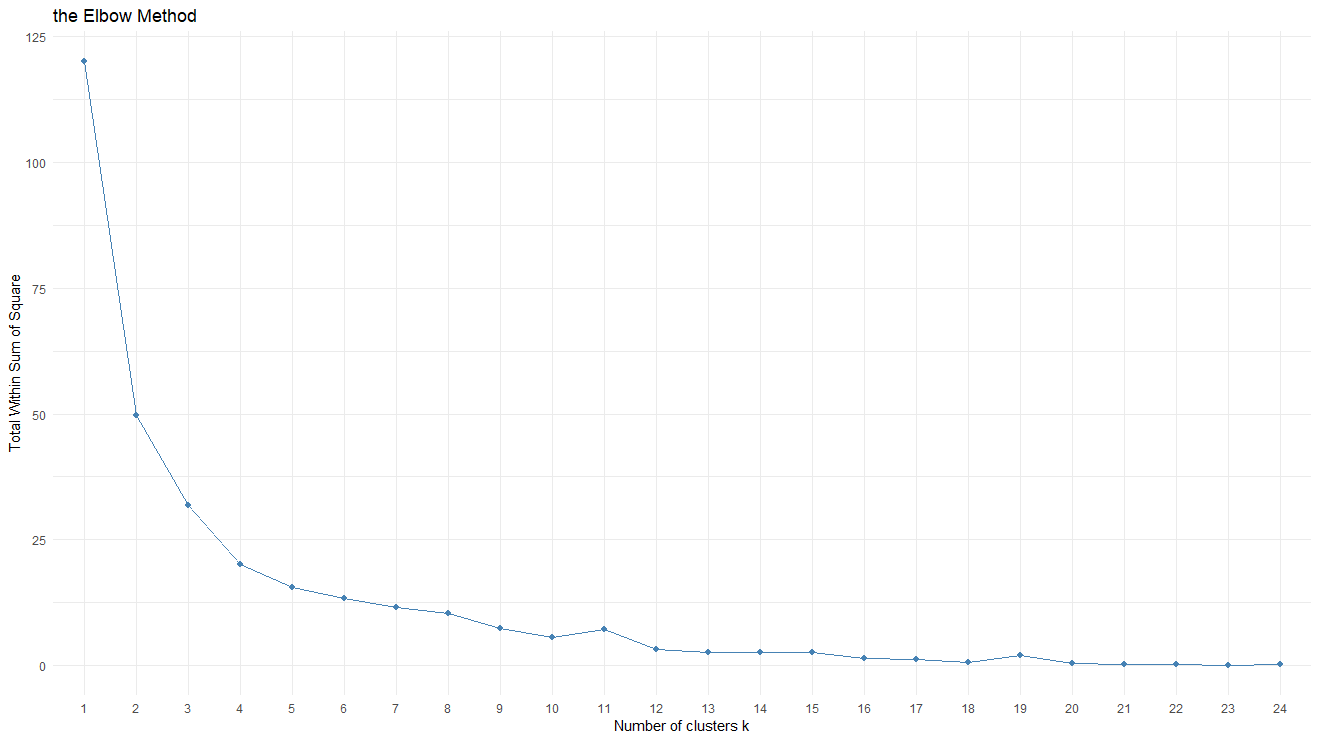

### 4) Зависимость скорости настройки от объема данных
Алгоритм работает за O(nkdi), где n - количество векторов d-мерного пространства, k - количество кластеров, i - количество итераций необходимых для сходимости.
